# What other Python packages (numpy, pandas, matplotlib) are people using and how is that usage related to the ML framework choice.

## Results Summary:
- Numpy, pandas, and matplotlib are the three most common imports.
- There's a moderate correlation between bs4 and requests. This makes sense, since BeautifulSoup (a popular parsing module within the bs4 package) requires the requests packages to scrape public html pages. There are moderate correlations between sklearn and numpy, pandas, and os. There is a very strong correlation between sklearn and re, a package that is used frequently to pre-process text data. There are no correlations over 0.3 with keras or tensorflow, the other two popular machine learning packages.
- a -> b means that if a is imported into a notebook, b has at least a 75% chance of also being imported into that notebook. Further, the probability that both a and b are imported into a notebook is at least 5%. This rule is true for:
    - datetime -> time
    - numpy, pandas, re -> sklearn
    - pandas, re, os -> sklearn
    - matplotlib, numpy, pandas, re -> sklearn
    - numpy, pandas, re, os -> sklearn

----------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from apyori import apriori  

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load(lang='python')

# Python Package Imports

In [3]:
def agg_imports(list_of_lists):
    overall = []
    for li in list_of_lists:
        for l in li:
            overall.append(l[0].split('.')[0])
    return list(set(overall))

nb_imports = cells.groupby('file')['imports'].aggregate(agg_imports).reset_index()

In [4]:
all_imports = []
for im in nb_imports.imports:
    all_imports += im

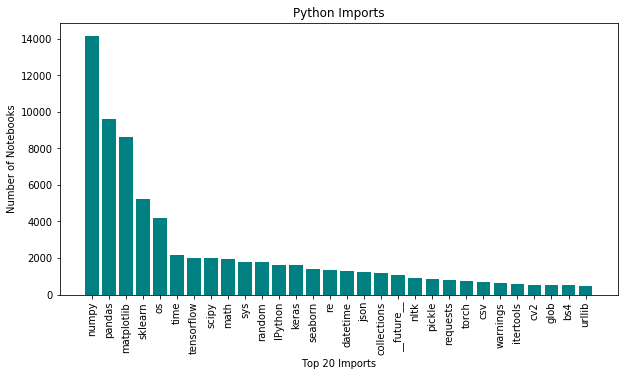

In [5]:
top_n = pd.Series(all_imports).value_counts()[0:30]
top_packages = top_n.index
pos = np.arange(len(top_packages))
height = top_n.values
fig = plt.figure(figsize=(10,5))
plt.bar(pos, height, color = 'teal')
plt.xticks(pos, top_packages, rotation = 90)
plt.title('Python Imports')
plt.xlabel('Top 20 Imports')
plt.ylabel('Number of Notebooks')
plt.show()

Numpy, pandas, and matplotlib are the three most common imports.

In [6]:
has_import = nb_imports[[n != [] for n in nb_imports.imports]]

In [7]:
prop_imports = {}
for im in top_n.index:
    prop = sum([im in row.imports 
                for _, row in nb_imports.iterrows()
            ])/len(nb_imports)
    prop_has = sum([im in row.imports 
                for _, row in has_import.iterrows()
            ])/len(has_import)
    prop_imports[im] = (prop_has, prop)

In [8]:
prop_imports

{'numpy': (0.6596617119425935, 0.5909337563133948),
 'pandas': (0.4469502819067145, 0.40038402137162415),
 'matplotlib': (0.40212478449280087, 0.360228743164837),
 'sklearn': (0.24435021667210288, 0.21889218182577116),
 'os': (0.19397977727039747, 0.17376967065993237),
 'time': (0.10083407110572666, 0.0903285052385524),
 'tensorflow': (0.0937980522808816, 0.08402554576950369),
 'scipy': (0.09244676389730208, 0.08281504361981884),
 'math': (0.09174782162993336, 0.08218892181825771),
 'sys': (0.08252178370066633, 0.07392411403765078),
 'random': (0.08233539909603467, 0.07375714822390116),
 'IPython': (0.07576534178276874, 0.06787160328922653),
 'keras': (0.07455384185266296, 0.0667863254998539),
 'seaborn': (0.06495503471413261, 0.05818758609174771),
 're': (0.06379013093518475, 0.0571440497558125),
 'datetime': (0.05875774661013, 0.05263597278457236),
 'json': (0.056754112110339684, 0.050841090286763785),
 'collections': (0.05489026606402311, 0.04917143214926744),
 '__future__': (0.0492

# What packages are frequently used together in a notebooks?

In [9]:
for column in top_packages:
    cells[column] = [0]*len(cells)
    cells.loc[[column in ' '.join([i[0] for i in im]) for im in cells['imports']],column] = 1

In [10]:
def atleast1(l):
    return sum(l) > 0

top_by_nb = cells.groupby('file')[top_packages].aggregate(atleast1).reset_index()

## Test for independence of all packages
Ho: $\Sigma = \Sigma_0 =$ diagonal matrix of variances. All packages are imported independently.

Ha: $\Sigma \ne \Sigma_0$ Not all packages are imported independently.

U = det(sample covariance matrix) / product(sample variances)

Under the null hypothesis, we expect U = 1

In [11]:
cov = top_by_nb[top_packages].cov()
U = np.linalg.det(cov) / np.diag(cov).prod()
U

0.03291687487537417

U = 0.030 is very far from 1, providing very strong evidence that not all packages are imported independent.

## Not all packages are imported independently, so which are associated?

### Looking at correlations

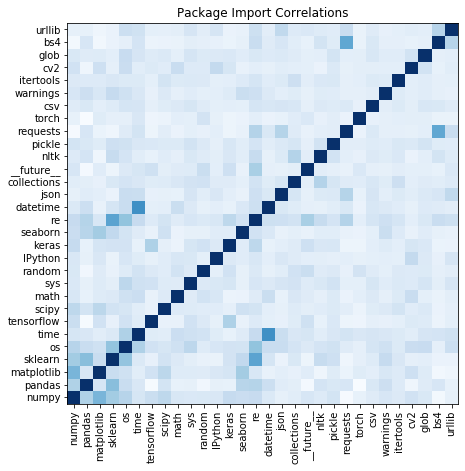

In [12]:
df = top_by_nb[top_packages].corr().transpose()
fig = plt.figure(figsize = (7,7))
plt.pcolor(df, cmap = 'Blues')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation = 90)
plt.title("Package Import Correlations")
plt.show()

#### Colors can be tricky to distinguish, objectively focus on correlations over 0.3.

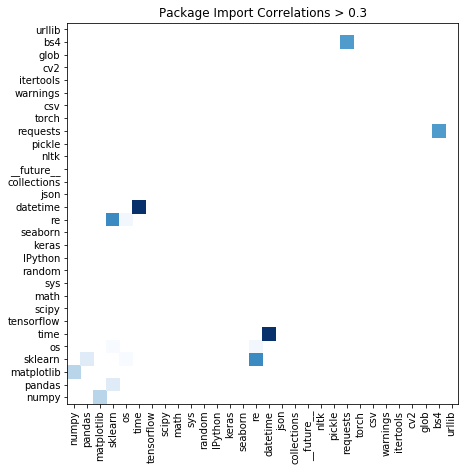

In [13]:
df_over_03 = df[np.logical_and(df > 0.3, df < 1)]
fig = plt.figure(figsize = (7,7))
plt.pcolor(df_over_03, cmap = 'Blues')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation = 90)
plt.title("Package Import Correlations > 0.3")
plt.show()

Frequently co-occuring (correlation > 0.3): 
- bs4 and requests
- datetime and time
- re and sklearn
- re and os
- os and sklearn
- sklearn and numpy
- sklearn and pandas
- matploltlib and numpy

There's a moderate correlation between bs4 and requests. This makes sense, since BeautifulSoup (a popular parsing module within the bs4 package) requires the requests packages to scrape public html pages. There are moderate correlations between sklearn and numpy, pandas, and os. There is a very strong correlation between sklearn and re, a package that is used frequently to pre-process text data. There are no correlations over 0.3 with keras or tensorflow, the other two popular machine learning packages.

### Looking at frequent item sets

Support = frequency of items. Minimum support = 5%, items have to occur together in at least 5% of notebooks.

Confidence = conditional probability. Minimum confidence = 75%, a -> b if pr(b|a) is at least 75%.

Lift compares confidence with expected confidence.

In [11]:
# convert data into correct format for input into apriori
# each record is a list of words, records = [['numpy', 'pandas', 'sklearn'], ['sklearn','os','re'], ...]
records = [list(top_packages[c[top_packages].values]) for _, c in top_by_nb.iterrows()]

In [12]:
association_rules = apriori(records, min_support=0.05, min_confidence=0.75, min_lift=3, min_length=2)  
association_results = list(association_rules)  

In [13]:
for item in association_results:
    # first index of the inner list
    # Contains base item and add item
    first = item.ordered_statistics[0].items_base
    second = item.ordered_statistics[0].items_add
    print(', '.join([x for x in first]), '->', ', '.join([x for x in second]))

    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    #print("Lift: " + str(item[2][0][3]))
    print("=====================================")

pandas, re, matplotlib -> sklearn
Support: 0.0659515970265775
Confidence: 0.7564726494062681
numpy, pandas, re -> sklearn
Support: 0.12255184820610299
Confidence: 0.7607458912768646
pandas, re, os -> sklearn
Support: 0.08005498795017141
Confidence: 0.7945090112851608
numpy, pandas, re, matplotlib -> sklearn
Support: 0.06293065408506161
Confidence: 0.7806315789473686
numpy, pandas, re, os -> sklearn
Support: 0.07413190319405316
Confidence: 0.8351816443594646


In [14]:
pr_pd_and_np = sum([(c['numpy'] + c['pandas']) == 2 for _, c in top_by_nb.iterrows()]) / len(top_by_nb)
pr_np = sum([c['numpy'] for _, c in top_by_nb.iterrows()]) / len(top_by_nb)
pr_pd_given_np = pr_pd_and_np / pr_np
print('numpy -> pandas','\nSupport:', pr_pd_and_np,'\nConfidence:', pr_pd_given_np)

pr_pd = sum([c['pandas'] for _, c in top_by_nb.iterrows()]) / len(top_by_nb)
pr_np_given_pd = pr_pd_and_np / pr_pd
print('\npandas -> numpy','\nSupport:', pr_pd_and_np,'\nConfidence:', pr_np_given_pd, '\n')

numpy -> pandas 
Support: 0.29286174943145177 
Confidence: 0.5046351805819564

pandas -> numpy 
Support: 0.29286174943145177 
Confidence: 0.7399339650958364 



**Association Rules**

a -> b means that if a is imported into a notebook, b has at least a 75% chance of also being imported into that notebook. Further, the probability that both a and b are imported into a notebook is at least 5%.
- datetime -> time
- numpy, pandas, re -> sklearn
- pandas, re, os -> sklearn
- matplotlib, numpy, pandas, re -> sklearn
- numpy, pandas, re, os -> sklearn

**Other Notes**
- numpy -> pandas and vise versa have the support, but not the confidence

<center> <a href = 3_Frameworks.ipynb>ML Framework Use &lt;</a> | <a href = 5_Models.ipynb>&gt; ML Model Use</a> <center>